<h1 align="center">Web Traffic Forecasting of English Wikipedia pages  </h1>

Introduction: <br> 
<br>
I have chosen this project as part of Udacity Data Science Capstone Project. I have been provided time series data representing a number of daily views of different Wikipedia articles along with the name of the article and type of the traffic this time-series represents like mobile, desktop, spider/crawler & all. Based on the available data, the task at hand is to forecast/predict future traffic to Wikipedia pages. Dataset provided by Kaggle, <a href="https://www.kaggle.com/c/web-traffic-time-series-forecasting/data">here</a> <br>

Questions to Solve: <br>
<br>
1> Does the traffic (by month) follow same pattern across overall/access types/agent types ? <br>
2> Identify top 10 pages (by traffic) & if they have similar patterns ?<br>
3> Forecast/Predict the traffic of top page using different time-series models & evaluate which model is better ?<br>
4> Evaluate the models using **RMSE** metric to find which of the models are better are forecasting

In [118]:
# Lets start with Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import pmdarima
import statsmodels.api as sm

from pmdarima import auto_arima
from itertools import repeat
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import array
from pandas import concat

In [119]:
# Import CSV File & check dataset contents

train = pd.read_csv("Web_Traffic.csv")
train.head()

,Page,01-07-2015,02-07-2015,03-07-2015,04-07-2015,05-07-2015,06-07-2015,07-07-2015,08-07-2015,09-07-2015,...,01-09-2017,02-09-2017,03-09-2017,04-09-2017,05-09-2017,06-09-2017,07-09-2017,08-09-2017,09-09-2017,10-09-2017
0,!vote_en.wikipedia.org_desktop_all-agents,3.0,4.0,7.0,4.0,4.0,2.0,3.0,7.0,2.0,...,8.0,6.0,4.0,5.0,4.0,2.0,2.0,9.0,3.0,3.0
1,"""Awaken,_My_Love!""_en.wikipedia.org_desktop_al...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,608.0,551.0,582.0,631.0,617.0,684.0,649.0,640.0,498.0,546.0
2,"""European_Society_for_Clinical_Investigation""_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
3,"""Weird_Al""_Yankovic_en.wikipedia.org_desktop_a...",2403.0,20136.0,1850.0,1432.0,1351.0,1792.0,1710.0,2039.0,1957.0,...,1336.0,1106.0,1309.0,1334.0,1381.0,1370.0,2041.0,1381.0,1084.0,1157.0
4,100_metres_en.wikipedia.org_desktop_all-agents,982.0,881.0,794.0,979.0,1191.0,1057.0,1184.0,860.0,1259.0,...,436.0,374.0,422.0,467.0,641.0,525.0,490.0,580.0,539.0,496.0


In [120]:
# Shape of the dataframe

train.shape

(24111, 804)

In [121]:
# Lets take a closer look at wikipedia page

train['Page'][0]

'!vote_en.wikipedia.org_desktop_all-agents'

Column __"Page"__ is a combination of Article Name, Language, Access Type (Desktop/Mobile/All) and Agent Type (Spider/All) separated by underscore (_)


In [122]:
# Splitting the Page column string into 4 columns topic/language/access/type.

Page_New = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.*\_(?P<access>.*)\_(?P<type>.*)')
Page_New.head()

,topic,lang,access,type
0,!vote,en,desktop,all-agents
1,"""Awaken,_My_Love!""",en,desktop,all-agents
2,"""European_Society_for_Clinical_Investigation""",en,desktop,all-agents
3,"""Weird_Al""_Yankovic",en,desktop,all-agents
4,100_metres,en,desktop,all-agents


In [123]:
# Join both train and Page_New DF

df = train.merge(Page_New, how='inner', left_index=True, right_index=True)

In [124]:
# Rearranging 4 columns at the end to the beginning

for col in repeat(None, 4):
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]


In [125]:
# Sample rows of merged data frame

df.head()

,topic,lang,access,type,Page,01-07-2015,02-07-2015,03-07-2015,04-07-2015,05-07-2015,...,01-09-2017,02-09-2017,03-09-2017,04-09-2017,05-09-2017,06-09-2017,07-09-2017,08-09-2017,09-09-2017,10-09-2017
0,!vote,en,desktop,all-agents,!vote_en.wikipedia.org_desktop_all-agents,3.0,4.0,7.0,4.0,4.0,...,8.0,6.0,4.0,5.0,4.0,2.0,2.0,9.0,3.0,3.0
1,"""Awaken,_My_Love!""",en,desktop,all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_desktop_al...",NaN,NaN,NaN,NaN,NaN,...,608.0,551.0,582.0,631.0,617.0,684.0,649.0,640.0,498.0,546.0
2,"""European_Society_for_Clinical_Investigation""",en,desktop,all-agents,"""European_Society_for_Clinical_Investigation""_...",NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
3,"""Weird_Al""_Yankovic",en,desktop,all-agents,"""Weird_Al""_Yankovic_en.wikipedia.org_desktop_a...",2403.0,20136.0,1850.0,1432.0,1351.0,...,1336.0,1106.0,1309.0,1334.0,1381.0,1370.0,2041.0,1381.0,1084.0,1157.0
4,100_metres,en,desktop,all-agents,100_metres_en.wikipedia.org_desktop_all-agents,982.0,881.0,794.0,979.0,1191.0,...,436.0,374.0,422.0,467.0,641.0,525.0,490.0,580.0,539.0,496.0


In [126]:
df.shape

(24111, 808)

In [127]:
# Check for Missing data by rows (absolute & %)

Rows_Missing = df.isnull().any(axis=1).sum()
Rows_Missing_perc = Rows_Missing/df.shape[0] * 100
print("Number of rows missing data {} and percentage of rows missing {:.2f}%". format(Rows_Missing, Rows_Missing_perc))

Number of rows missing data 7431 and percentage of rows missing 30.82%


7431(30.8%) of the rows have missing data.  

According to the data source, dataset doesn't distinguish between traffic values of 0 or missing values.  
Missing values may mean a) traffic was zero OR b) data not available for the day.  

Some of the rows have missing data at the beginning or at the end, where as some of them have missing data in between. 

In [128]:
# Changing Missing data to zero
df.fillna(0)

,topic,lang,access,type,Page,01-07-2015,02-07-2015,03-07-2015,04-07-2015,05-07-2015,...,01-09-2017,02-09-2017,03-09-2017,04-09-2017,05-09-2017,06-09-2017,07-09-2017,08-09-2017,09-09-2017,10-09-2017
0,!vote,en,desktop,all-agents,!vote_en.wikipedia.org_desktop_all-agents,3.0,4.0,7.0,4.0,4.0,...,8.0,6.0,4.0,5.0,4.0,2.0,2.0,9.0,3.0,3.0
1,"""Awaken,_My_Love!""",en,desktop,all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_desktop_al...",0.0,0.0,0.0,0.0,0.0,...,608.0,551.0,582.0,631.0,617.0,684.0,649.0,640.0,498.0,546.0
2,"""European_Society_for_Clinical_Investigation""",en,desktop,all-agents,"""European_Society_for_Clinical_Investigation""_...",0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
3,"""Weird_Al""_Yankovic",en,desktop,all-agents,"""Weird_Al""_Yankovic_en.wikipedia.org_desktop_a...",2403.0,20136.0,1850.0,1432.0,1351.0,...,1336.0,1106.0,1309.0,1334.0,1381.0,1370.0,2041.0,1381.0,1084.0,1157.0
4,100_metres,en,desktop,all-agents,100_metres_en.wikipedia.org_desktop_all-agents,982.0,881.0,794.0,979.0,1191.0,...,436.0,374.0,422.0,467.0,641.0,525.0,490.0,580.0,539.0,496.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24106,Zikanyrops_sparsa,en,all-access,all-agents,Zikanyrops_sparsa_en.wikipedia.org_all-access_...,1.0,5.0,2.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,0.0
24107,Zillur_Rahman_John,en,all-access,all-agents,Zillur_Rahman_John_en.wikipedia.org_all-access...,7.0,9.0,3.0,6.0,4.0,...,5.0,4.0,4.0,6.0,5.0,6.0,5.0,6.0,7.0,5.0
24108,Zitadelle,en,all-access,all-agents,Zitadelle_en.wikipedia.org_all-access_all-agents,10.0,6.0,4.0,8.0,13.0,...,7.0,8.0,4.0,2.0,7.0,6.0,4.0,12.0,3.0,5.0
24109,"Zovashen_(Dzhannatlu),_Ararat",en,all-access,all-agents,"Zovashen_(Dzhannatlu),_Ararat_en.wikipedia.org...",0.0,0.0,1.0,1.0,1.0,...,12.0,10.0,8.0,6.0,4.0,4.0,5.0,6.0,6.0,9.0


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24111 entries, 0 to 24110
Columns: 808 entries, topic to 10-09-2017
dtypes: float64(803), object(5)
memory usage: 148.6+ MB


In [130]:
df[['access','type']].describe()

,access,type
count,24111,24111
unique,3,2
top,all-access,all-agents
freq,14352,19179


In [131]:
# What are the unique values in columns

lang_col = df['lang'].unique()
access_col = df['access'].unique()
type_col = df['type'].unique()
print(list(lang_col))
print(list(access_col))
print(list(type_col))

['en']
['desktop', 'all-access', 'mobile-web']
['all-agents', 'spider']


In [291]:
# Create a Function for visualization

def func_graph(plot, col):
    dataset = df.groupby(plot).sum().T
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.groupby(pd.Grouper(freq = 'M')).mean().dropna()
    dataset['month'] = 100*dataset.index.year + dataset.index.month
    dataset = dataset.reset_index(drop=True)
    dataset = pd.melt(dataset, id_vars = ['month'], value_vars=col)
    fig = plt.figure(1, figsize=[12,8])
    ax = sns.pointplot(x="month", y="value", hue=plot, data=dataset)
    ax.set(xlabel='Year-Month', ylabel='Mean Visits')
    plt.xticks(rotation=45)
    plt.title('Monthwise traffic')

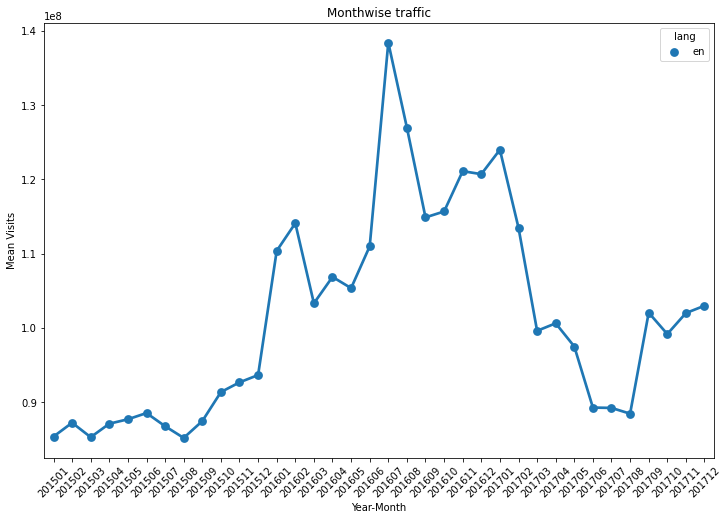

In [292]:
# Visualize overall traffic by month
func_graph("lang", lang_col)

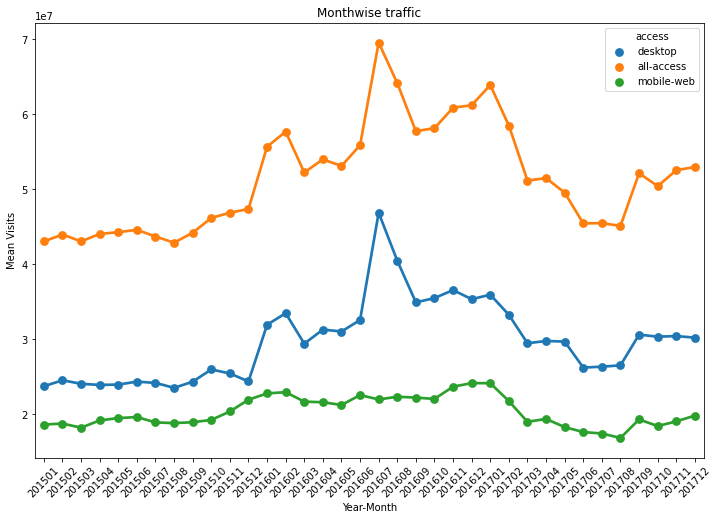

In [293]:
# Visualize access traffic by month
func_graph("access", access_col)

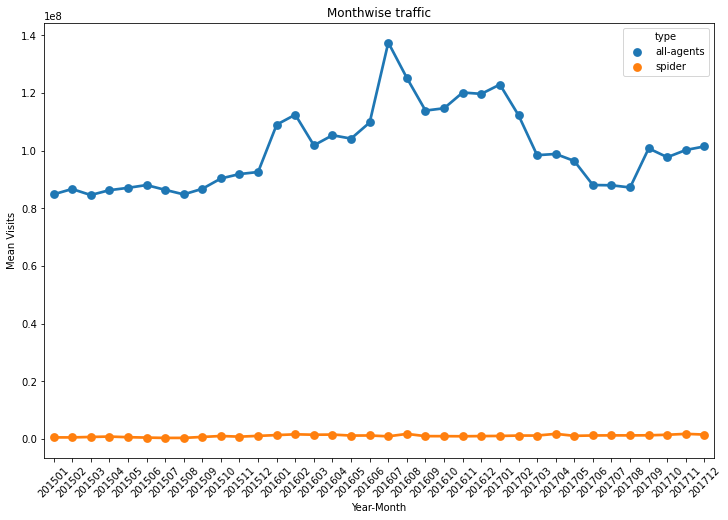

In [294]:
# Visualize type traffic by month
func_graph("type", type_col)

**Q1 Does the traffic (by month) follow same pattern across overall/access types/agent types ?**  

*  Looking at the trends from overall traffic, there seems to be increase in traffic from Month 08 to Month 12 across all years except for huge spike in the beginning of year 2016.<br>
*  The huge spike in 2016 is driven due to desktop (PC) as seen from access type graph. Mobile is pretty much flat.
*  Agent type "spider" (web crawler) traffic is very flat as seen in agent type graph.


In [136]:
# Overall traffic is combination of Desktop (PC), Mobile & Spider agent.
# To avoid double counting of traffic, lets subset the data to include Pages with only all access and all agents

df_new = df[(df['access'] == 'all-access') & (df['type'] == 'all-agents')]
df_new.head()

,topic,lang,access,type,Page,01-07-2015,02-07-2015,03-07-2015,04-07-2015,05-07-2015,...,01-09-2017,02-09-2017,03-09-2017,04-09-2017,05-09-2017,06-09-2017,07-09-2017,08-09-2017,09-09-2017,10-09-2017
9907,!vote,en,all-access,all-agents,!vote_en.wikipedia.org_all-access_all-agents,3.0,4.0,7.0,4.0,4.0,...,16.0,12.0,10.0,7.0,11.0,8.0,5.0,15.0,6.0,9.0
9908,"""Awaken,_My_Love!""",en,all-access,all-agents,"""Awaken,_My_Love!""_en.wikipedia.org_all-access...",NaN,NaN,NaN,NaN,NaN,...,1090.0,1090.0,1100.0,1164.0,1047.0,1144.0,1092.0,1065.0,978.0,972.0
9909,"""European_Society_for_Clinical_Investigation""",en,all-access,all-agents,"""European_Society_for_Clinical_Investigation""_...",NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
9910,"""Weird_Al""_Yankovic",en,all-access,all-agents,"""Weird_Al""_Yankovic_en.wikipedia.org_all-acces...",3966.0,27052.0,3867.0,3117.0,3578.0,...,2849.0,2927.0,3241.0,3052.0,2954.0,2664.0,6515.0,3076.0,2946.0,NaN
9911,'Tis_the_Season,en,all-access,all-agents,'Tis_the_Season_en.wikipedia.org_all-access_al...,34.0,30.0,32.0,33.0,17.0,...,45.0,59.0,34.0,36.0,67.0,46.0,30.0,54.0,42.0,NaN


In [137]:
df_new.shape

(9420, 808)

In [138]:
# Lets understand top 10 Wiki pages that drive the traffic

df_new['row_sum'] = df_new.sum(axis=1)
df_new[['Page', 'row_sum']].sort_values(by = 'row_sum', ascending=False).head(10)



<ipython-input-138-be96c5dd297f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['row_sum'] = df_new.sum(axis=1)


,Page,row_sum
11274,Main_Page_en.wikipedia.org_all-access_all-agents,1.719626e+10
11881,Special:Search_en.wikipedia.org_all-access_all...,1.900465e+09
11873,Special:Book_en.wikipedia.org_all-access_all-a...,2.170866e+08
13631,404.php_en.wikipedia.org_all-access_all-agents,1.577805e+08
12338,XHamster_en.wikipedia.org_all-access_all-agents,1.272769e+08
13773,Donald_Trump_en.wikipedia.org_all-access_all-a...,1.158465e+08
11875,Special:CreateAccount_en.wikipedia.org_all-acc...,8.248204e+07
13390,Special:RecentChanges_en.wikipedia.org_all-acc...,8.143538e+07
14531,Web_scraping_en.wikipedia.org_all-access_all-a...,5.848631e+07
13392,Special:Watchlist_en.wikipedia.org_all-access_...,5.737690e+07


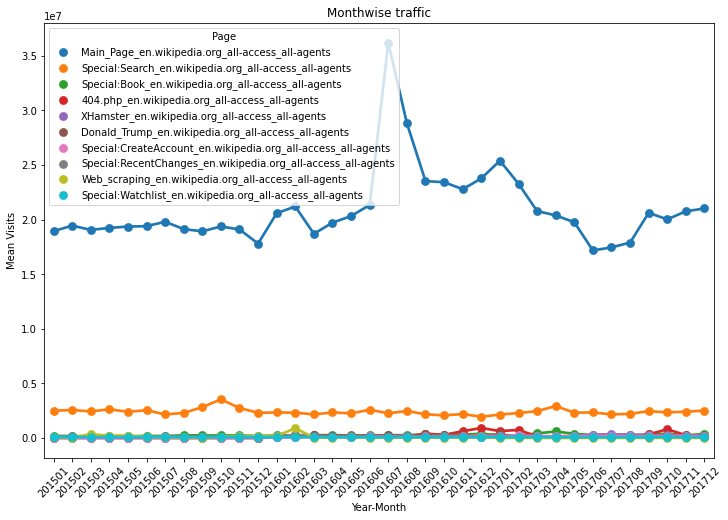

In [295]:
# Lets see the trends of top 10 wikipedia articles

df_modified = df_new.sort_values(by = 'row_sum', ascending=False).head(10)
Page_col = df_modified['Page'].unique()

func_graph("Page", Page_col)

**Q2 Identify top 10 pages (by traffic) & if they have similar patterns ?** <br>

*  We can find top 10 pages by total traffic listed above.<br>
*  There are two pages that are significantly contributing to the overall Wikipedia traffic:<br>
1 Main_Page_en.wikipedia.org <br>
2 Special:Search_en.wikipedia.org <br>
* However overall Wikipedia traffic trends is influenced by Main_Page. Rest of the pages are almost flat.

In [140]:
# Lets study in detail about the Main_Page_en.wikipedia.org_all-access_all-agents

In [141]:
train = df_modified[df_modified['Page'] == 'Main_Page_en.wikipedia.org_all-access_all-agents']
train = train.iloc[:,5:808].T

train.index = pd.to_datetime(train.index, format = '%d-%m-%Y').strftime('%Y-%m-%d')
train.index = pd.DatetimeIndex(train.index, freq='D')

train.index.names=['Date']
train.columns = ['Main_Page']
train = train.astype(int)

train

,Main_Page
Date,
2015-07-01,20381245
2015-07-02,20752194
2015-07-03,19573967
2015-07-04,20439645
2015-07-05,20772109
...,...
2017-09-06,17499187
2017-09-07,18273046
2017-09-08,14116665


In [142]:
train.shape

(803, 1)

In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Main_Page  803 non-null    int32
dtypes: int32(1)
memory usage: 9.4 KB


In [296]:
# Before starting with the modeling, lets decompose the data to check for trends/seasonality 

def seasonal_decomp(y):
    #decomposition = sm.tsa.seasonal_decompose(y, model='additive',period='infer',extrapolate_trend='freq')
    decomposition = sm.tsa.seasonal_decompose(y.values,period=365,extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(12,8)
    plt.show()

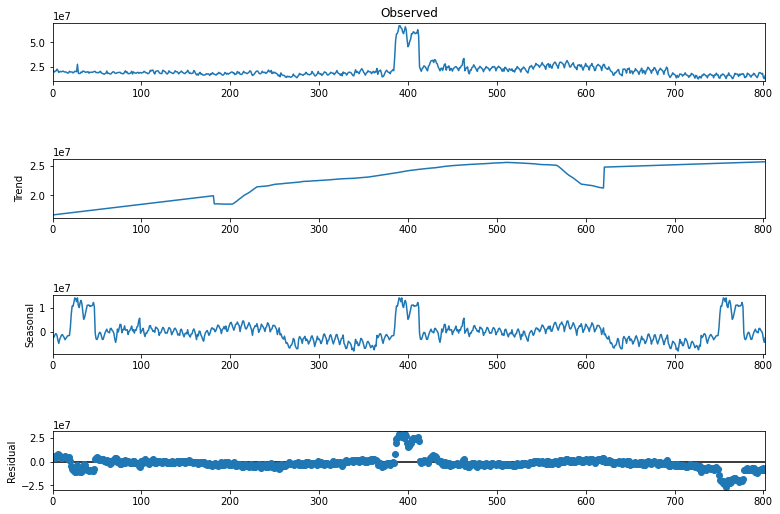

In [297]:
seasonal_decomp(train)

Looking at the above decomposed graph: <br>
*  Trend - Trend indicates traffic of "Main_Page" has been increasing gradually
*  Seasonality - We see spike at the beginning of the year and then reduces and stays stable & say there is a yearly seaonality.
*  Residual - Residual (what's left) appears to be stationary

In [146]:
# We need to check if the data is stationary or not. In addition to Visualization above, lets perform (ADF) Augmented Dickey-Fuller Test


def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [147]:
ADF_test(train, 'traffic')

 > Is the traffic stationary ?
Test statistic = -4.494
P-value = 0.000
Critical values :
	1%: -3.438750669890019 - The data is  stationary with 99% confidence
	5%: -2.8652477937238703 - The data is  stationary with 95% confidence
	10%: -2.56874438754281 - The data is  stationary with 90% confidence


Our data is stationary, we can proceed with splitting train & test data set and model

In [148]:
#Convert Pandas DF to series, Split Train & Test

train = train.squeeze() 

y_train = train['2015-07-01':'2017-07-12']
y_test = train['2017-07-13':'2017-09-10']

In [149]:
len(y_train)

743

In [150]:
len(y_test)

60

As we have seasonality in our data, lets use Seasonal ARIMA model

In [151]:
# Tuning to find optimal p,d,q,P,D,Q,m for SARIMAX

model=auto_arima(y_train,start_p=0,d=1,start_q=0,
max_p=5,max_d=5,max_q=5, start_P=0,
D=1, start_Q=0, max_P=5,max_D=5,
max_Q=5, m=12, seasonal=True,
error_action='warn',trace=True,
supress_warnings=True,stepwise=True,
random_state=20,n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=24055.379, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=23922.596, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=24035.149, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=23840.127, Time=0.89 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=23816.675, Time=2.29 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=23807.868, Time=3.39 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=23778.295, Time=7.43 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=15.64 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=8.66 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=23712.997, Time=5.25 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=23756.896, Time=3.16 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=12.53 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=7.78 sec
 ARIMA(0,1,1)(5,1,0)[12]         

After hyper tuning, we will fit the best model with minimum Akaike Information Criterion (AIC) score with the following parameters:
p=0,q=1,d=0
P=5,Q=1,D=0,m=12

In [152]:
# Train the model, fit the model
model = SARIMAX(y_train, order=(0,1,0), seasonal_order=(5,1,0,12))
SARIMAX_mod = model.fit()

In [153]:
SARIMAX_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Main_Page   No. Observations:                  743
Model:             SARIMAX(0, 1, 0)x(5, 1, 0, 12)   Log Likelihood              -11850.498
Date:                            Sat, 20 Mar 2021   AIC                          23712.997
Time:                                    09:52:20   BIC                          23740.555
Sample:                                07-01-2015   HQIC                         23723.629
                                     - 07-12-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7195      0.018    -39.415      0.000      -0.755      -0.684
ar.S.L24      -0.6736      0.043    -15.529      0.000      -0.759      -0.589
ar.S.L36      -0.4708      0.045    -10.410      0.000      -0.559      -0.382
ar.S.L48      -0.3189      0.045     -7.076      0.000      -0.407      -0.231
ar.S.L60      -0.2424      0.028     -8.618      0.000      -0.298      -0.187
sigma2      7.546e+12   1.45e-15   5.21e+27      0.000    7.55e+12    7.55e+12
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):             38424.76
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+43. Standard errors may be unstable.
"""

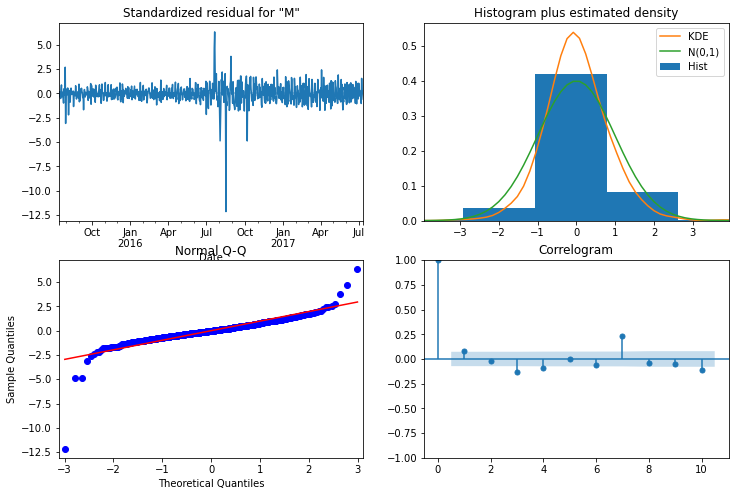

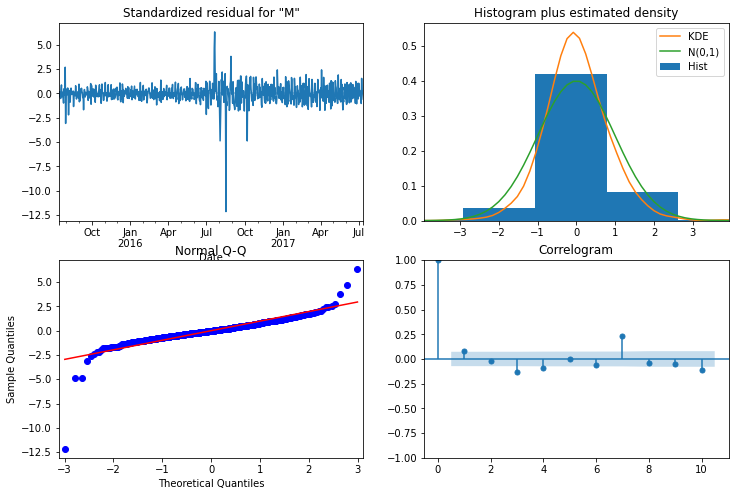

In [298]:
# Lets run model diagnostics
SARIMAX_mod.plot_diagnostics(figsize=(12,8))

Though Not Perfect, residual plot indicates the residuals are normally distributed around 0 & indicates model is good

Text(0.5, 1.0, 'Prediction/Forecast of Main_Page_en.wikipedia.org')

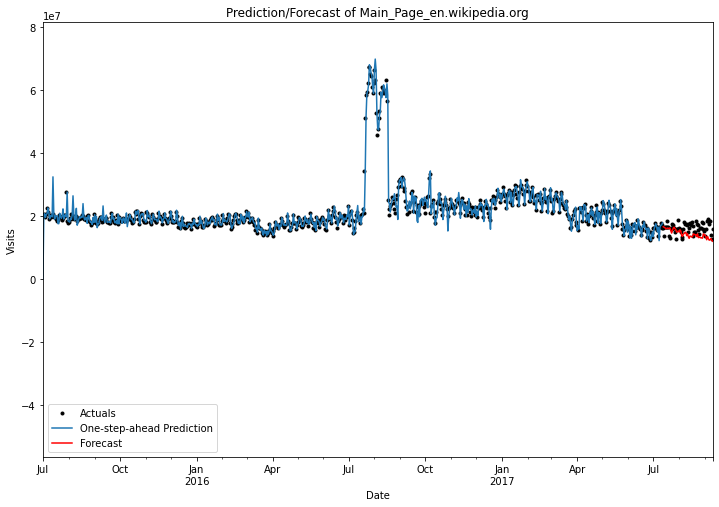

In [299]:
# Predict entire dataset & forecast for the test duration of 60 days
pred = SARIMAX_mod.get_prediction()
forecast = SARIMAX_mod.get_forecast(steps=60)

# Plot the actual(observed)/Predicted/Forecasted data
fig, ax = plt.subplots(figsize=(12,8))
train.plot(ax=ax, style='k.', label='Actuals')
pred.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
pred_ci = pred.conf_int(alpha=0.05)
pred_index = np.arange(len(pred_ci))
ax.fill_between(pred_index[2:], pred_ci.iloc[2:, 0], pred_ci.iloc[2:, 1], alpha=0.1)
forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(pred_ci), len(pred_ci) + len(forecast_ci))
ax.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)


# Set labels
legend = ax.legend(loc='lower left');
ax.set_xlabel('Date')
ax.set_ylabel('Visits')
ax.set_title('Prediction/Forecast of Main_Page_en.wikipedia.org')


#In the chart below:
#Dots - the actual/observed data
#Blue line - shows the predicted values
#Red line - indicates the forecasted values



In [156]:
# Lets check model efficiency using RMSE

mse = round(mean_squared_error(y_test, forecast.predicted_mean),2)
rmse_sarimax = round(sqrt(mse),2)
print("mse is:{}.".format(mse))
print("rmse is:{}.".format(rmse_sarimax))

mse is:8350746124247.64.
rmse is:2889765.76.


RMSE is higher for this model (indicates higher error), lets try another model - fbprophet

In [157]:
# Lets Change the index to a column as required for fbprophet model.

y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)


y_train.head()


,Date,Main_Page
0,2015-07-01,20381245
1,2015-07-02,20752194
2,2015-07-03,19573967
3,2015-07-04,20439645
4,2015-07-05,20772109


In [158]:
#Lets model & fit

Prophet_train = y_train.rename(columns={'Date' : 'ds', 'Main_Page' : 'y'})
Prophet_mod = Prophet(interval_width=0.95,daily_seasonality=True)
Prophet_mod.fit(Prophet_train)

In [159]:
# Lets prepare the test dataset

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)


y_test.head()

,Date,Main_Page
0,2017-07-13,16288600
1,2017-07-14,13607723
2,2017-07-15,16563435
3,2017-07-16,16434823
4,2017-07-17,18355982


In [160]:
Future_df = y_test.rename(columns={'Date' : 'ds', 'Main_Page' : 'y'})
Future_df.head()

,ds,y
0,2017-07-13,16288600
1,2017-07-14,13607723
2,2017-07-15,16563435
3,2017-07-16,16434823
4,2017-07-17,18355982


Text(0.5, 1.0, 'Main Page WikiPedia Traffic')

<Figure size 864x576 with 0 Axes>

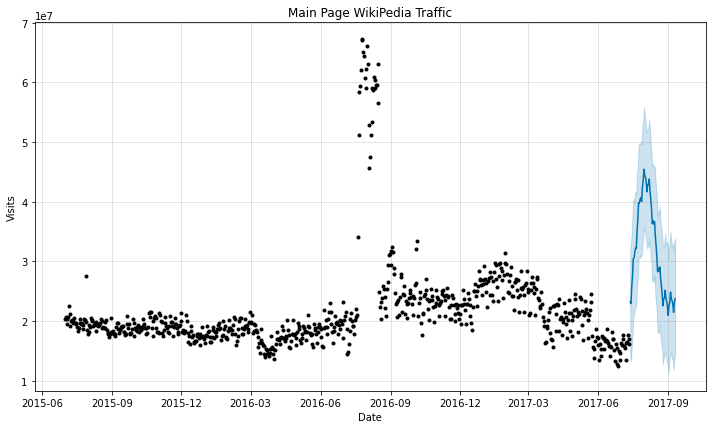

In [300]:
# Forecast using Fb Prophet model

Fb_Model_Forecast = Prophet_mod.predict(Future_df)

plt.figure(figsize =(12,8))
Prophet_mod.plot(Fb_Model_Forecast, xlabel = 'Date', ylabel = 'Visits')
plt.title('Main Page WikiPedia Traffic')

In [162]:
# FB Model Forecast data

Fb_Model_Forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-13,2.882393e+07,1.422563e+07,3.347904e+07,2.882393e+07,2.882393e+07,-5.554170e+06,-5.554170e+06,-5.554170e+06,-6.277524e+06,...,-5.184722e+05,-5.184722e+05,-5.184722e+05,1.241827e+06,1.241827e+06,1.241827e+06,0.0,0.0,0.0,2.326976e+07
1,2017-07-14,2.880784e+07,1.318336e+07,3.224384e+07,2.880702e+07,2.880817e+07,-5.870963e+06,-5.870963e+06,-5.870963e+06,-6.277524e+06,...,-1.958480e+06,-1.958480e+06,-1.958480e+06,2.365041e+06,2.365041e+06,2.365041e+06,0.0,0.0,0.0,2.293688e+07
2,2017-07-15,2.879175e+07,1.622805e+07,3.545476e+07,2.878932e+07,2.879321e+07,-3.037420e+06,-3.037420e+06,-3.037420e+06,-6.277524e+06,...,-3.269569e+05,-3.269569e+05,-3.269569e+05,3.567061e+06,3.567061e+06,3.567061e+06,0.0,0.0,0.0,2.575433e+07
3,2017-07-16,2.877565e+07,1.794286e+07,3.767053e+07,2.877116e+07,2.877900e+07,-1.215077e+06,-1.215077e+06,-1.215077e+06,-6.277524e+06,...,2.253201e+05,2.253201e+05,2.253201e+05,4.837127e+06,4.837127e+06,4.837127e+06,0.0,0.0,0.0,2.756057e+07
4,2017-07-17,2.875956e+07,2.099485e+07,3.967050e+07,2.875147e+07,2.876490e+07,1.687440e+06,1.687440e+06,1.687440e+06,-6.277524e+06,...,1.802340e+06,1.802340e+06,1.802340e+06,6.162624e+06,6.162624e+06,6.162624e+06,0.0,0.0,0.0,3.044700e+07
5,2017-07-18,2.874346e+07,2.097170e+07,4.026399e+07,2.873137e+07,2.875046e+07,1.858661e+06,1.858661e+06,1.858661e+06,-6.277524e+06,...,6.068988e+05,6.068988e+05,6.068988e+05,7.529286e+06,7.529286e+06,7.529286e+06,0.0,0.0,0.0,3.060212e+07
6,2017-07-19,2.872737e+07,2.196270e+07,4.173856e+07,2.871115e+07,2.873667e+07,2.813267e+06,2.813267e+06,2.813267e+06,-6.277524e+06,...,1.693502e+05,1.693502e+05,1.693502e+05,8.921441e+06,8.921441e+06,8.921441e+06,0.0,0.0,0.0,3.154064e+07
7,2017-07-20,2.871128e+07,2.179949e+07,4.193771e+07,2.869011e+07,2.872303e+07,3.526299e+06,3.526299e+06,3.526299e+06,-6.277524e+06,...,-5.184722e+05,-5.184722e+05,-5.184722e+05,1.032229e+07,1.032229e+07,1.032229e+07,0.0,0.0,0.0,3.223757e+07
8,2017-07-21,2.869518e+07,2.209778e+07,4.150716e+07,2.867000e+07,2.871029e+07,3.478243e+06,3.478243e+06,3.478243e+06,-6.277524e+06,...,-1.958480e+06,-1.958480e+06,-1.958480e+06,1.171425e+07,1.171425e+07,1.171425e+07,0.0,0.0,0.0,3.217342e+07
9,2017-07-22,2.867909e+07,2.569097e+07,4.443362e+07,2.864994e+07,2.869803e+07,6.474748e+06,6.474748e+06,6.474748e+06,-6.277524e+06,...,-3.269569e+05,-3.269569e+05,-3.269569e+05,1.307923e+07,1.307923e+07,1.307923e+07,0.0,0.0,0.0,3.515384e+07


In [164]:
# Calculate RMSE of Fb Prophet Model

y_pred = Fb_Model_Forecast.loc[:, 'yhat']
mse = round(mean_squared_error(y_test['Main_Page'], y_pred),2)
rmse_prophet = round(sqrt(mse),2)
print("mse is:{}.".format(mse))
print("rmse is:{}.".format(rmse_prophet))

mse is:313452642328152.75.
rmse is:17704593.82.


FB Prophet Model RMSE score is very higher compared to our earlier SARIMAX model

In [214]:
# Lets use Short Term Long Term Memory (LSTM) model next

In [215]:
# Using Data From Random Row for Training and Testing
X = train[0:802]
y = train[1:803]

In [216]:
y

Date
2015-07-02    20752194
2015-07-03    19573967
2015-07-04    20439645
2015-07-05    20772109
2015-07-06    22544669
                ...   
2017-09-06    17499187
2017-09-07    18273046
2017-09-08    14116665
2017-09-09    12696261
2017-09-10    15731110
Freq: D, Name: Main_Page, Length: 802, dtype: int32

In [217]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
X_train = list(X_train)
y_train = list(y_train)

In [218]:
# Feature Scaling
sc = MinMaxScaler()
X_train = np.reshape(X_train, (-1,1))
y_train = np.reshape(y_train, (-1,1))
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

In [219]:
# Reshaping Array
X_train = np.reshape(X_train, (641, 1, 1))

In [220]:
# Initializing the RNN
regressor = Sequential()

In [221]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units=8, activation='relu', input_shape=( 1, 1)) )

In [222]:
# Adding the output layer
regressor.add(Dense(units=1))

In [223]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

In [224]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)

In [225]:
# Getting the predicted Web View
X = list(X)
inputs = X
inputs = np.reshape(inputs, (-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (802,1,1))
    
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

In [231]:

# Lets check model efficiency using RMSE

mse = round(mean_squared_error(y, y_pred),2)
rmse_LSTM = round(sqrt(mse),2)
print("mse is:{}.".format(mse))
print("rmse is:{}.".format(rmse_LSTM))

mse is:5703639180982.1.
rmse is:2388229.3.


Text(0, 0.5, 'Visits')

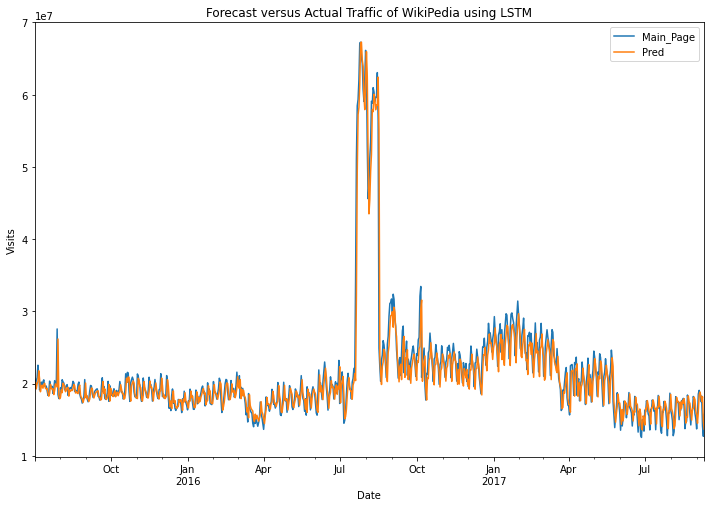

In [301]:
y = pd.DataFrame(y)
y['Main_Page']
y['Pred'] = y_pred
y.head()
y.plot(figsize = (12,8))
plt.title("Forecast versus Actual Traffic of WikiPedia using LSTM")
plt.xlabel("Date")
plt.ylabel("Visits")

__Lets evaluate the performance of various models using our metric RMSE__

In [263]:
print("RMSE of various models are: \nSARIMAX = {} \nFbProphet = {} \nLSTM = {}.".format(rmse_sarimax, rmse_prophet, rmse_LSTM))

RMSE of various models are: 
SARIMAX = 2889765.76 
FbProphet = 17704593.82 
LSTM = 2388229.3.


Comparing __RMSE__ metric of the above models used in forecasting, __SARIMAX__ model has lower RMSE compared to two other models.

__CONCLUSION__ <br>
<br>
1 Data consists of English WikiPedia pages traffic.<br>
2 By exploring data, found out, Page is combination of Topic_Language_AccessType_AgentType<br>
3 From Visualization, Overall Traffic pattern contains seasonality & is driven by desktop (PC) (Mobile & Spider are flat)<br>
4 Of all the pages, Main_Page contributed to the overall traffic & had similar trends.<br>
5 Decomposed the traffic & found out data had upward trend & seasonality as well. From ADF test, our traffic was stationary<br>
6 Prepared the data for modeling & fit the model using SARIMAX, FbProphet & LSTM and SARIMAX has lower RMSE value & hence better model to forecast time series data

**NEXT STEPS**

We can look at taking difference of the data (single or double difference) or log transform the data, fit the models and see if time-series forecasts get better.